<a href="https://colab.research.google.com/github/QFrankQ/Applied-Numerical-Optimization/blob/main/MCMC_and_Probit_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Missing data imputation in Probit regression**#
In this programming assignment, we will implement a Markov chain Monte Carlo (MCMC) algorithm for binary regression with missing features. Refer to the slides for lecture 23.  \\

**Note**: For submitting your solutions, do the following:  \\
**1.** Add link to this colab notebook in the last cell of this notebook.  
**2.** **File -> Save -> Print -> Save as PDF** and upload the pdf to gradescope.

(No work) **Step 1**: Generate data: we have provided code to randomly generate data, including the ground truth regression coefficient vector, feature matrix, and binary outcomes. We also provide you the truncrandn function; it generates random numbers from the truncated normal distribution. It has the following input-output format; you can input scalars but the function is implemented in a way such that you can input vectors and generate multiple random numbers at the same time.

We also give you ways to generate from the inverse Wishart distribution; code is provided for that part.

In [ ]:
import scipy.stats
import numpy as np
import numpy.random as npr
from numpy.linalg import inv, cholesky
from scipy.stats import chi2
import matplotlib.pyplot as plt
import math

def invwishartrand(nu, phi):
    return inv(wishartrand(nu, inv(phi)))

def wishartrand(nu, phi):
    dim = phi.shape[0]
    chol = cholesky(phi)
    foo = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                foo[i,j] = np.sqrt(chi2.rvs(nu-(i+1)+1))
            else:
                foo[i,j]  = npr.normal(0,1)
    return np.dot(chol, np.dot(foo, np.dot(foo.T, chol.T)))

def truncrandn(mu,sigma,indic):

    L = len(indic)
    tempno = np.zeros((L,))
    idx1 = np.where(indic==1)[0]
    idx0 = np.where(indic==0)[0]

    # generate the positive side
    resid = scipy.stats.norm.cdf(0.0,loc = mu[idx1], scale = sigma[idx1])
    resid1 = resid + np.random.uniform(size=(len(idx1),)) * (1.0 - resid)
    tempno[idx1] = scipy.stats.norm.ppf(resid1,loc = mu[idx1], scale = sigma[idx1])

    # generate the negative side
    resid = scipy.stats.norm.cdf(0.0,loc = mu[idx0], scale = sigma[idx0])
    resid0 = np.random.uniform(size=(len(idx0),)) * resid
    tempno[idx0] = scipy.stats.norm.ppf(resid0,loc = mu[idx0], scale = sigma[idx0])

    idxinf = np.where(np.isinf(tempno))[0]
    if len(idxinf) > 0:
        # flip to the negative side to sample!!!
        resid = scipy.stats.norm.cdf(0.0,loc = -mu[idxinf], scale = sigma[idxinf])
        resid_inf = np.random.uniform(size=(len(idxinf),)) * resid
        tempno[idxinf] = 2.0 * mu[idxinf] - \
            scipy.stats.norm.ppf(resid_inf,loc = mu[idxinf], scale = sigma[idxinf])

    return tempno
      

In [ ]:
# generate data
np.random.seed(0)
N = 200
P = 10
pct_miss = .2

X = np.random.normal(size=(N,P))
beta = .2 * np.random.normal(size=(P,))
y = np.random.binomial(1,1.0/(1+np.exp(-np.dot(X,beta))))
X[np.random.binomial(1,pct_miss,size=(N,P)) == 1] = np.nan

**Step 2**: Baseline. Use what you have implemented in PA1 to run logistic regression on this data. For a missing feature in an observation, do an imputation by taking the average of this feature’s values across all observations where it is not missing. Implement it as logreg misx function, with two inputs: Xin and y, the former is the feature matrix with missing entries in it while the latter is the binary-valued vector of observations.

In [ ]:
z = lambda y, A, x: np.exp((2*y - 1) * (A @ x))
f = lambda y, A, x: np.sum(np.log(1 + np.exp(-(2*y - 1) * (A @ x) )))
fp = lambda y, A, x: -A.T @ ((2*y - 1) / (1 + z(y, A, x)))
fpp = lambda y, A, x: A.T @ (np.diag(1 / (2 + z(y, A, x) + 1/z(y, A, x)))) @ A

def logreg_misx(Xin,y):

    # l2 regularized logistic regression
    N,P = Xin.shape

    # # impute with simple averages
    X = np.copy(Xin)
    for ii in range(N):
        for jj in range(P):
            if np.isnan(Xin[ii,jj]):
                X[ii,jj] = np.nanmean(Xin[:,jj])

    """
    Add your code here
    """
    x = np.zeros(P)
    A = X
    it = 0
    ss = 10
    tol = 1e-15  
    change = math.inf
    alpha, beta = 1, 1/2
    while it < 10000 and change > tol:
      grad = fp(y, A, x)
      while f(y, A, x - ss * grad) > f(y, A, x) - (alpha/2)*ss*(np.linalg.norm(grad)**2):
        ss = beta * ss 
      x_change = - ss * fp(y, A, x)
      new_x = x + x_change
      old_obj = f(y, A, x)
      change = abs(f(y, A, new_x) - old_obj) / abs(old_obj)
      it += 1
      x = new_x
    return x


**Step 3**: Implement the MCMC algorithm. We have provided all other parts of the code; all you need to do is to implement sampling steps for $z_i$, $\beta$, and $x_i^{M_i}$ for all $i$.

In [ ]:
def proreg_misx_b(X_input,y):

    # the main function
    (N,P) = X_input.shape

    # some algo parameters
    T = 1000
    burnin = int(T/2)

    mu_beta = np.zeros((P,))
    Sig_beta = np.eye(P)
    Pres_beta = np.linalg.inv(Sig_beta)
    kappa_0 = 1.0
    nu_0 = 1.0
    mu_0 = np.zeros((P,))
    Psi_0 = np.eye(P)

    # allocate variables
    mask = np.double(~np.isnan(X_input)) # this is a pre-calculation
    X = np.zeros((N,P,T))
    z = np.zeros((N,T))
    beta = np.zeros((P,T))
    mu = np.zeros((P,T))
    Sig = np.zeros((P,P,T))

    # initialize
    # X initialization: simply average the unobserved X entries
    for ii in range(N):
        for jj in range(P):
            if np.isnan(X_input[ii,jj]):
                X[ii,jj,0] = np.nanmean(X_input[:,jj]) #.05 * np.random.normal()
            else:
                X[ii,jj,0] = X_input[ii,jj]

    # beta initialization: initialize with log reg
    beta[:,0] = logreg_misx(X_input,y)
    # beta[:,0] = np.zeros((P,))
    z[:,0] = truncrandn(np.dot(X[:,:,0],beta[:,0]),np.ones((N,)),y)

    # mu and Sigma calculated according to imputations
    mu[:,0] = np.mean(X[:,:,0],axis=0)
    Sig[:,:,0] = np.dot(X[:,:,0].T,X[:,:,0]) / np.double(N) + .1 * np.eye(P)

    for tt in range(1,T):

        if tt%100 == 0:
            print('iteration ',tt)

        # sample z
        """
        Add your code here
        """
        z[:,tt] = truncrandn(np.dot(X[:,:,tt-1],beta[:,tt-1]),np.ones((N,)),y)
        znow = np.copy(z[:,tt])
        Xnow = np.copy(X[:,:,tt-1])
        # sample beta
        """
        Add your code here
        """
        Pres_n = np.dot(Xnow.T,Xnow) + Pres_beta
        Sig_n = np.linalg.inv(Pres_n)
        mu_n = np.dot(Sig_n,np.dot(Pres_beta,mu_beta) + np.dot(Xnow.T,znow))
        beta[:,tt] = np.random.multivariate_normal(mu_n,Sig_n)
        Pres_beta = Pres_n
        Sig_beta = Sig_n
        mu_beta = mu_n

        # now sample the missing X values
        """
        Add your code here
        """
        for ii in range(N):
          mis_idx = np.where(mask[ii,] == 0)[0]
          if len(mis_idx) > 0:
            obs_idx = np.where(mask[ii,] > 0)[0]
            mum = mu[:,tt-1][mis_idx]
            muo = mu[:,tt-1][obs_idx]
            Sigmm = Sig[:,:,tt-1][mis_idx,][:,mis_idx]
            Sigmo = Sig[:,:,tt-1][mis_idx,][:,obs_idx]
            Sigom = Sig[:,:,tt-1][obs_idx,][:,mis_idx]
            Sigoo = Sig[:,:,tt-1][obs_idx,][:,obs_idx]
            mubar = mum + np.dot(np.dot(Sigmo, inv(Sigoo)), (Xnow[ii,obs_idx] - muo))
            Sigbar = Sigmm - np.dot(np.dot(Sigmo, inv(Sigoo)), Sigom)

            zbar = znow[ii] - np.dot(Xnow[ii, obs_idx].T, beta[obs_idx,tt])
            Sigprime = inv(inv(Sigbar) + np.dot(beta[mis_idx, tt], beta[mis_idx,tt].T))
            muprime = np.dot(Sigprime, np.dot(inv(Sigbar), mubar) + np.dot(zbar, beta[mis_idx,tt]))
            X[ii,mis_idx,tt] = np.random.multivariate_normal(muprime, Sigprime)
            X[ii, obs_idx, tt] = X_input[ii, obs_idx]


        # now sample mu and Sig values
        # first calculate sufficient stats
        Xnow = X[:,:,tt]
        xbar = np.mean(Xnow,axis=0)
        C = np.zeros((P,P))
        for ii in range(N):
            C += np.outer(Xnow[ii,] - xbar,Xnow[ii,] - xbar)
        # then use them to get new IW params
        nu_t = nu_0 + N
        Sig_t = Psi_0 + C + kappa_0 * N / nu_t * np.outer(xbar-mu_0,xbar-mu_0)
        Sig[:,:,tt] = invwishartrand(nu_t,Sig_t)
        # now use the newly sampled Sig to sample new mu
        kappa_t = kappa_0 + N
        mu_t = (kappa_0 * mu_0 + N * xbar) / kappa_t
        mu[:,tt] = np.random.multivariate_normal(mu_t,Sig[:,:,tt] / kappa_t)

    # run the freakin' loop on and on... till convergence!
    betaout = np.mean(beta[:,burnin:],axis=1)
    Xout = np.mean(X[:,:,burnin:],axis=2)
    muout = np.mean(mu[:,burnin:],axis=1)
    Sigout = np.mean(Sig[:,:,burnin:],axis=2)

    return betaout,Xout,muout,Sigout

**Step 4a)**: Investigate. Run the MCMC algorithm for a total of 1000 iterations with the first 500 as burn-in, and set your own hyperparameter values. Obtain an estimated regression coefficient vector and compare it to the ground truth and calculate the $l_2$-norm of the difference. Do the same for the logistic regression baseline; what do you observe?

In [ ]:
betahat_b = proreg_misx_b(X,y)[0]
betahat_o = logreg_misx(X,y)

print('MCMC probit error = ',np.linalg.norm(betahat_b-beta) / np.linalg.norm(beta))
print('Logistic regression error = ',np.linalg.norm(betahat_o-beta) / np.linalg.norm(beta))

iteration  100
iteration  200
iteration  300
iteration  400
iteration  500
iteration  600
iteration  700
iteration  800
iteration  900
MCMC probit error =  0.32077982842541003
Logistic regression error =  0.558257587166397


*Answer the questions and discuss your findings here*

The MCMC probit error is lower than the logistic regression error

**Step 4b)**: Plot the values of the randomly generated samples of latent variables over iterations. Pick three entries in $\beta$ and discuss whether you think the number of iterations and burnin (1000 and 500) are enough.

In [ ]:
def proreg_misx_b_alt(X_input,y):

    # the main function
    (N,P) = X_input.shape

    # some algo parameters
    T = 1000
    burnin = int(T/2)

    mu_beta = np.zeros((P,))
    Sig_beta = np.eye(P)
    Pres_beta = np.linalg.inv(Sig_beta)
    kappa_0 = 1.0
    nu_0 = 1.0
    mu_0 = np.zeros((P,))
    Psi_0 = np.eye(P)

    # allocate variables
    mask = np.double(~np.isnan(X_input)) # this is a pre-calculation
    X = np.zeros((N,P,T))
    z = np.zeros((N,T))
    beta = np.zeros((P,T))
    mu = np.zeros((P,T))
    Sig = np.zeros((P,P,T))

    # initialize
    # X initialization: simply average the unobserved X entries
    for ii in range(N):
        for jj in range(P):
            if np.isnan(X_input[ii,jj]):
                X[ii,jj,0] = np.nanmean(X_input[:,jj]) #.05 * np.random.normal()
            else:
                X[ii,jj,0] = X_input[ii,jj]

    # beta initialization: initialize with log reg
    beta[:,0] = logreg_misx(X_input,y)
    # beta[:,0] = np.zeros((P,))
    z[:,0] = truncrandn(np.dot(X[:,:,0],beta[:,0]),np.ones((N,)),y)

    # mu and Sigma calculated according to imputations
    mu[:,0] = np.mean(X[:,:,0],axis=0)
    Sig[:,:,0] = np.dot(X[:,:,0].T,X[:,:,0]) / np.double(N) + .1 * np.eye(P)

    for tt in range(1,T):

        if tt%100 == 0:
            print('iteration ',tt)

        # sample z
        """
        Add your code here
        """
        z[:,tt] = truncrandn(np.dot(X[:,:,tt-1],beta[:,tt-1]),np.ones((N,)),y)
        znow = np.copy(z[:,tt])
        Xnow = np.copy(X[:,:,tt-1])
        # sample beta
        """
        Add your code here
        """
        Pres_n = np.dot(Xnow.T,Xnow) + Pres_beta
        Sig_n = np.linalg.inv(Pres_n)
        mu_n = np.dot(Sig_n,np.dot(Pres_beta,mu_beta) + np.dot(Xnow.T,znow))
        beta[:,tt] = np.random.multivariate_normal(mu_n,Sig_n)
        Pres_beta = Pres_n
        Sig_beta = Sig_n
        mu_beta = mu_n

        # now sample the missing X values
        """
        Add your code here
        """
        for ii in range(N):
          mis_idx = np.where(mask[ii,] == 0)[0]
          if len(mis_idx) > 0:
            obs_idx = np.where(mask[ii,] > 0)[0]
            mum = mu[:,tt-1][mis_idx]
            muo = mu[:,tt-1][obs_idx]
            Sigmm = Sig[:,:,tt-1][mis_idx,][:,mis_idx]
            Sigmo = Sig[:,:,tt-1][mis_idx,][:,obs_idx]
            Sigom = Sig[:,:,tt-1][obs_idx,][:,mis_idx]
            Sigoo = Sig[:,:,tt-1][obs_idx,][:,obs_idx]
            mubar = mum + np.dot(np.dot(Sigmo, inv(Sigoo)), (X[ii,obs_idx, tt] - muo))
            Sigbar = Sigmm - np.dot(np.dot(Sigmo, inv(Sigoo)), Sigom)

            #missed implementation
            zbar = z[ii,tt] - np.dot(X[ii, obs_idx, tt].T, beta[obs_idx,tt])
            Sigprime = inv(inv(Sigbar) + np.dot(beta[mis_idx, tt], beta[mis_idx,tt].T))
            muprime = np.dot(Sigprime, np.dot(inv(Sigbar), mubar) + np.dot(zbar, beta[mis_idx,tt]))
            ##
            X[ii,mis_idx,tt] = np.random.multivariate_normal(muprime, Sigprime)
            X[ii, obs_idx, tt] = X_input[ii, obs_idx]


        # now sample mu and Sig values
        # first calculate sufficient stats
        Xnow = X[:,:,tt]
        xbar = np.mean(Xnow,axis=0)
        C = np.zeros((P,P))
        for ii in range(N):
            C += np.outer(Xnow[ii,] - xbar,Xnow[ii,] - xbar)
        # then use them to get new IW params
        nu_t = nu_0 + N
        Sig_t = Psi_0 + C + kappa_0 * N / nu_t * np.outer(xbar-mu_0,xbar-mu_0)
        Sig[:,:,tt] = invwishartrand(nu_t,Sig_t)
        # now use the newly sampled Sig to sample new mu
        kappa_t = kappa_0 + N
        mu_t = (kappa_0 * mu_0 + N * xbar) / kappa_t
        mu[:,tt] = np.random.multivariate_normal(mu_t,Sig[:,:,tt] / kappa_t)

    # run the freakin' loop on and on... till convergence!
    betaout = np.mean(beta[:,burnin:],axis=1)
    Xout = np.mean(X[:,:,burnin:],axis=2)
    muout = np.mean(mu[:,burnin:],axis=1)
    Sigout = np.mean(Sig[:,:,burnin:],axis=2)

    return beta, X, mu, Sig
betaout, Xout, muout, Sigout = proreg_misx_b_alt(X,y)

iteration  100
iteration  200
iteration  300
iteration  400
iteration  500
iteration  600
iteration  700
iteration  800
iteration  900


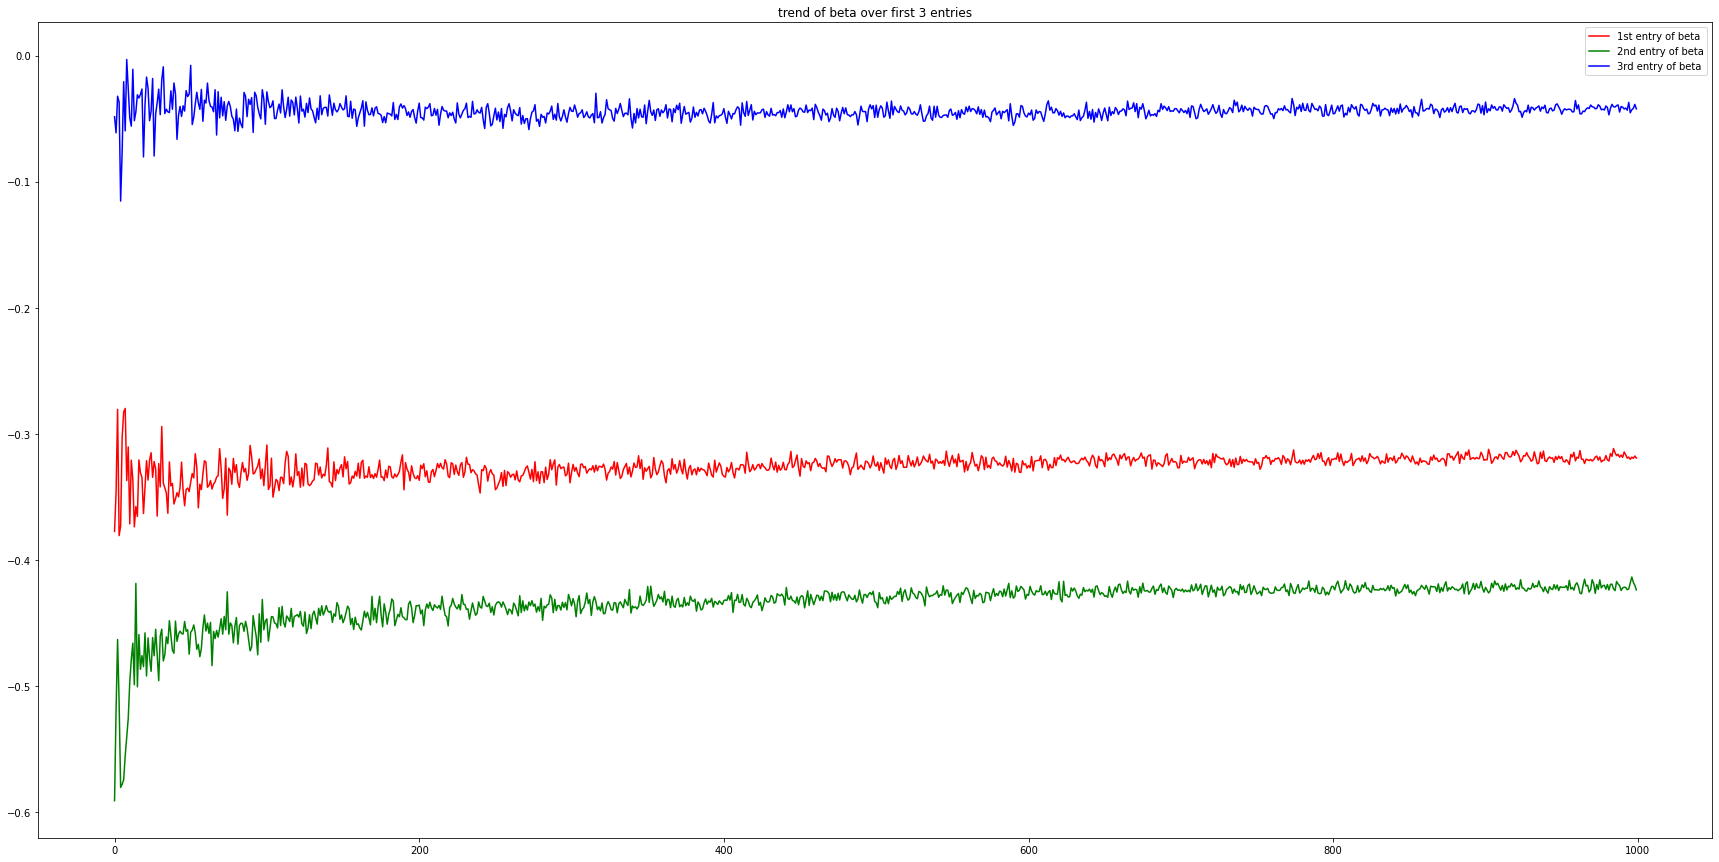

In [ ]:
"""
Add your code here
"""
beta1 = betaout[0]
beta2 = betaout[1]
beta3 = betaout[2]

#fig, axs = plt.subplots(1, figsize = (30, 30))

plt.figure(figsize = (30, 15))
plt.plot(beta1,'r', label = '1st entry of beta')
plt.plot(beta2,'g', label = '2nd entry of beta')
plt.plot(beta3,'b', label = '3rd entry of beta')
plt.title("trend of beta over first 3 entries")
plt.legend()
plt.show()

*Answer the questions and discuss your findings here

The individual beta are converging, which implies that 1000 iterations and burin of 500 is enough

**Step 4c)**: Investigate the posterior distributions. Again, pick some entries in $\beta$ and plot histograms of their density. Compare these with the prior and the ground-truth values; what do you observe?

first entry of ground truth beta: -0.3065842106860256
second entry of ground truth beta: -0.3423940328188443
third entry of ground truth beta: 0.009227011791136986


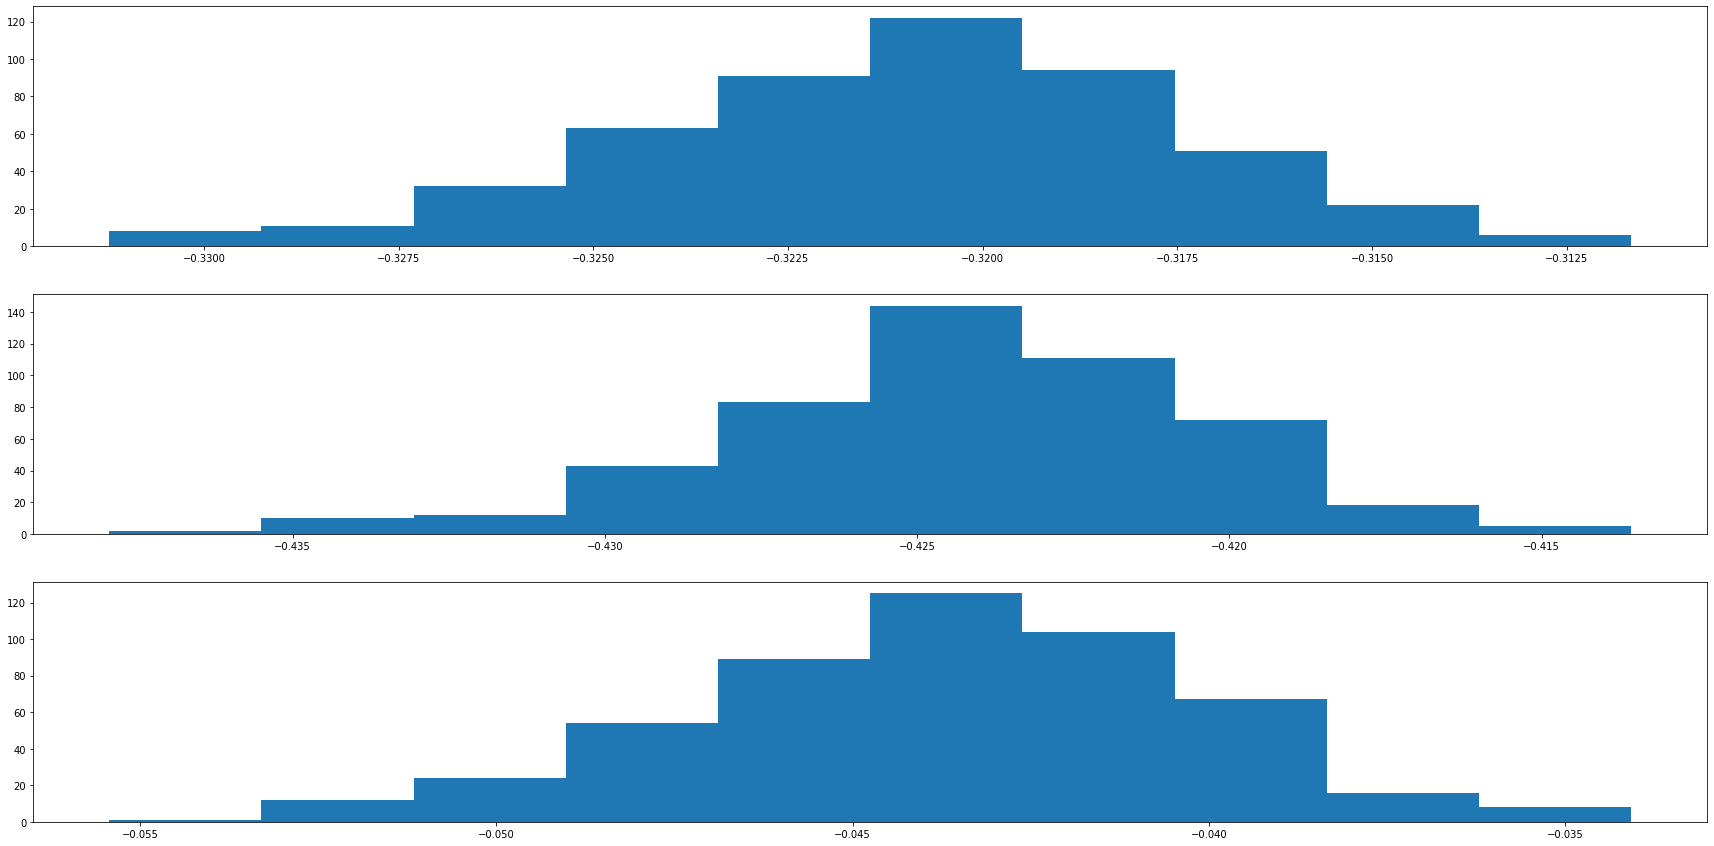

In [ ]:
"""
Add your code here
"""
print(f"first entry of ground truth beta: {beta[0]}")
print(f"second entry of ground truth beta: {beta[1]}")
print(f"third entry of ground truth beta: {beta[2]}")

fig, axs = plt.subplots(3, figsize = (30, 15))
axs[0].hist(beta1[500:])
axs[1].hist(beta2[500:])
axs[2].hist(beta3[500:])
plt.show()


*Answer the questions and discuss your findings here*

The posterior distribution is distibuted differently from the prior, but is somewhat close to the groundtruth beta


#Add Colab link here: # 

https://colab.research.google.com/drive/1fhEHc_3Uy9tMh42x4XJ2-YP94MqyL3B8?authuser=1#scrollTo=haiuUvRmh9UC